In [2]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel
from stanify.calibrator.draws_data_mapper import draws2data2draws
from stanify.calibrator.calib_utilities import check_consistency
import random
random.seed(10)
import warnings
warnings.filterwarnings('ignore')

##  Developing model families using visual diagnostics and numeric summaries
If you run the user interface code which states input and output format as below, it creates specific model, data, plot (two `.stan`, two `.nc files, multiple plots) in three folders. With minimal number of clicks, your model quality can be inspected. This aim of this vignette is to inspect how given the two outputs (model and data) can be analyzed for your next move.

keyword: simulation-based calibration, pair plots, divergence, InferenceData

Vensim model is as below, we estimate `prey_birth_frac`, `pred_birth_frac` from the model with assumed value `prey_death_frac` as .05, and `pred_death_frac` as .8, `process_noise_scale` .1.
<div>
<img src="../vensim_models/prey_predator/prey_predator_twoest.png" width="500"/>
</div>

## user interface

11:35:14 - cmdstanpy - INFO - compiling stan file /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N15Q2R3/draws2data.stan to exe file /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N15Q2R3/draws2data
11:35:21 - cmdstanpy - INFO - compiled model executable: /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N15Q2R3/draws2data
11:35:21 - cmdstanpy - WARNING - Stan compiler has produced 1 warnings:
11:35:21 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc --include-paths=/Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N15Q2R3 --o=/Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N15Q2R3/draws2data.hpp /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N15Q2R3/draws2data.stan
Warning in '/Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N15Q2R3/draws2data.stan', line 34, column 4: Declaration
    of arrays by placing b

chain 1 |          | 00:00 Status

11:35:21 - cmdstanpy - INFO - CmdStan done processing.


11:35:22 - cmdstanpy - INFO - compiling stan file /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N15Q2R3/data2draws.stan to exe file /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N15Q2R3/data2draws
11:35:31 - cmdstanpy - INFO - compiled model executable: /Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N15Q2R3/data2draws
11:35:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:35:58 - cmdstanpy - INFO - CmdStan done processing.
11:35:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N15Q2R3/data2draws.stan', line 62, column 8 to column 59)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/hyunjimoon/Dropbox/stanify/vignette/stan_files/prey_predator_S1N15Q2R3/data2draws.stan', line 62, column 8 to column 59)
Consider re-running with show_console=True if the above output is unclear!


<Figure size 640x480 with 0 Axes>

<Figure size 2944x552 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

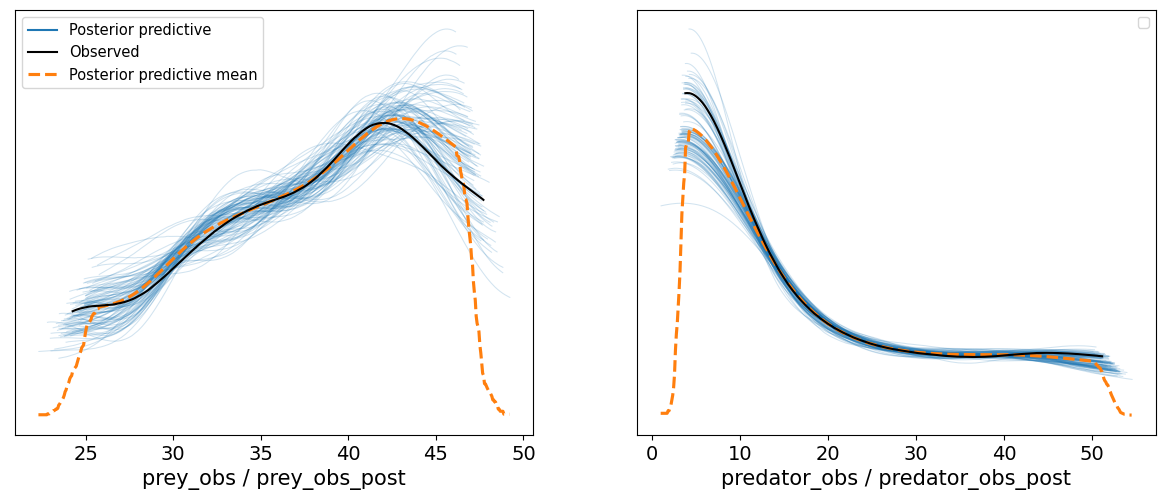

<Figure size 2208x1656 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [3]:
modelname = "prey_predator_S1N15Q2R3"
precision ={
    "S": 1, # # of draws from prior
    "M": 100, # # of draws from posterior (# of chains * # of draws from each chain)
    "N": 15, # # of observation
    "R": 3, # # of subgroups for hierarchical Bayes
}

setting = {
    "est_param_names": ["prey_birth_frac", "pred_birth_frac"],
    "hier_est_param_names" : ["prey_birth_frac"], #["pred_birth_frac"],
    "target_simulated_vector_names": ["prey", "predator"],
    "driving_vector_names": ["process_noise_uniform_driving"],
    "model_name": "prey_predator",
}

numeric = {
    "process_noise_uniform_driving": np.random.uniform(low=-.5, high=.5, size = precision['N']),
    'process_noise_scale': 0.1
}

prior = {
    ("prey_birth_frac", "normal", 0.8, 0.08, 0),
    ("pred_birth_frac", "normal", 0.05, 0.005, 0),
    ("m_noise_scale", "normal", 1, .1, 0)
}

output_format = dict(
    prior_predictive=["prey_obs", "predator_obs"],
    posterior_predictive=["prey_obs_post", "predator_obs_post"],
    log_likelihood={
        "loglik": "loglik"
    },
    coords={
        "time": [n for n in range(precision['N'])],
        "stock": setting['target_simulated_vector_names'],
        "region": [r for r in range(precision['R'])]
    },
    dims={
        'initial_outcome': ["stock"],
        'integrated_result': ["time", "stock"],
        'prey': ["time"],
        'predator': ["time"],
        'process_noise': ["time"],
        "prey_obs": ["time"],
        "predator_obs": ["time"],
    }
)

if check_consistency(setting, precision, numeric, prior, output_format):
    model = draws2data2draws('../vensim_models/prey_predator/prey_predator.mdl', setting, precision, numeric, prior, output_format)

	# Chain 2 had 17 divergent transitions (68.0%)
	# Chain 2 had 8 iterations at max treedepth (32.0%)
	# Chain 3 had 25 iterations at max treedepth (100.0%)

We load the produced data for plotting. Please refer to the end of this document for model (stan code) and data structure which is Stanify's main contribution, but not the scope here.

## diagnose numerically with InferenceData

`draws2data` have three groups: `prior`, `prior_predictive`, `samp_stats_prior`.First click the arrow to inspect dataset structure of each group. If you click database icon, it will show each data variable (estimated parameter, target simulated vectors for `prior` group, observed vector for `prior_predictive` group, lp and acceptance rate for `sample_stats_prior` group)

We load produced data for plotting. Please refer to the end of this document for model (stan code) and data structure which is Stanify's main contribution, but not the scope here.

`data2draws` have four groups: `posterior`, `prior_predictive`, `log_likelihood`, `samp_stats`, `observed_data`. First click the arrow below to inspect dataset structure of each group. If you click database icon, it will show each data variable (estimated parameter, target simulated vectors for `posterior` group, observed vector (adding measurement noise on target simulated vector posterior) for `osberved_data` group, loglikelihood of each posterior sample for `log_likelihood`, lp, acceptance_rate, tree_depth, energy (HMC alg.parameters) `sample_stats_prior` group)

In [ ]:
sbc = az.from_netcdf(f"data/{modelname}/sbc.nc")
sbc.prior

In [ ]:
sbc.observed_data.to_dataframe()[output_format['prior_predictive']].plot(by='region')

In [ ]:
sbc.posterior

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
for target in ['prey', 'predator']:
    ax.plot(sbc.prior[target].to_dataframe().values, label=f"{target}")
    ax.plot(sbc.prior_predictive[f'{target}_obs'].to_dataframe().values, label=f"{target}_obs")
ax.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
for target in ['prey', 'predator']:
    ax.plot(sbc.prior[target].mean('prior_draw').to_dataframe().values, label=f"{target}")
    ax.plot(sbc.prior_predictive[f'{target}_obs'].mean('prior_draw').to_dataframe().values, label=f"{target}_obs")
ax.legend()

`sbc_inferencedata` type consists of five groups. `prior`, `prior_predictive`, `samp_stats_prior`. Click the arrow to inspect dataset structure of each group. If you click database icon, it will show each data variable (estimated parameter, target simulated vectors for `prior` group, observed vector for `prior_predictive` group, lp and acceptance rate for `sample_stats_prior` group).
Posterior group is the estimated result and arviz summary summarizes both estimated result and the quality of the estiamtion.

In [ ]:
sbc.observed_data['prey_obs'].plot.scatter()

In [ ]:
sbc.posterior[setting['est_param_names']]

Compared to the ground truth .89, the value of `prey_birth_frac` sampled from normal(.8, .08), the mean of retrieved posterior values are 1.1, with 94% HDI .12 to 3.5.

In [ ]:
az.plot_posterior(sbc, var_names=setting['est_param_names'])

The [forest plot](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_forest.html) shows chains are stuck. Generally, each chain has different values, so plot_posterior that combines gives a semblance of kde, but for this model, each chain returns always the same exact value.

In [ ]:
az.plot_forest(sbc, var_names = setting['est_param_names'])

summary function returns mean, sd, credible interval for estimated parameter and target simulated vector. mcse, effective sample size (ess), r_hat tells quality of each variables' sample. Refer to [Stan manual](https://mc-stan.org/docs/reference-manual/effective-sample-size.html) for ess details. From large number of r_hat, the covergence of four chains are not good which is verified in more detail below. 1.2 is the usual threshold for r_hat.

Posterior samples include the ground truth .8 and .05.

In [ ]:
az.summary(sbc.posterior[setting['est_param_names']])

The PPC (prior/poseterior predictive check) plot is a standard way for Bayesian checking. It serves complementary role with simulation-based calibration (SBC). Two checks happen in different space: PPC in observation space as time series, SBC in parameter space as rank comparison between the ground truth and retrieved estimated samples. From the plot, posterior predictive's negative values is the most problematic which was expected as the currrent version uses normal likelihood. Changing this to lognoraml or negative binomial can solve this problem, but lognormal has thicker tail creating difficult posterior geometry and negative binomial need transformation to integer value which is known to be not accurate.

In [ ]:
az.plot_ppc(sbc, data_pairs = {'predator_obs':'predator_obs_post', 'prey_obs':'prey_obs_post'})

## Diagnose visually with time series, trace, pair, rank plots

### time series of target simulated and its measurement noise added observed vector

### pair plot

In [ ]:
ax = az.plot_pair(sbc,  var_names=['prey_birth_frac', 'pred_birth_frac', 'm_noise_scale'], divergences=True, textsize=22,)

## comparing observed data (from prior predictive) with posterior predictive

### rank plot
Rank plots are histograms of the ranked posterior draws (ranked over all chains) plotted separately for each chain. If all of the chains are targeting the same posterior, we expect the ranks in each chain to be uniform, whereas if one chain has a different location or scale parameter, this will be reflected in the deviation from uniformity. If rank plots of all chains look similar, this indicates good mixing of the chains. Plot below indicates bad mixing.



In [ ]:
fig, axes = plt.subplots(1, 4, figsize = (30, 20))
az.plot_rank(sbc, var_names=("prey_birth_frac", "pred_birth_frac"), ax=axes, )

## Appendix: stan code

In [ ]:
print(CmdStanModel(stan_file=f"stan_files/{modelname}/draws2data.stan").code())
print(CmdStanModel(stan_file=f"stan_files/{modelname}/data2draws.stan").code())